In [248]:
import numpy as np
import pandas as pd

In [249]:
rho_tank=4500 #kg/m3
m=4/86400#kg/s
P=172#bar
T=273.15+25
T1=T
Tref=10+273.15
Po=31

In [250]:
import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]
T=298
P1=100
def PRv2(Tc,Pc,mm,w,T,P):
    #Unidades: P, Pc: kPa, T, Tc: K, w: Adim, mm: kg/kmol
    R=8.314#J/mol-K
    Ru=R/mm
    mi=0.379642+1.48503*w-0.164423*w**2+0.016666*w**3
    alpha=(1+mi*(1-(T/Tc)**0.5))**2
    a=0.45724*((Ru)**2)*(Tc**2)*alpha/(Pc)
    b=0.0778*(Ru)*(Tc/Pc)
    A_may=a*P/(((Ru)**2)*(T**2))
    B_may=b*P/((Ru)*T)
    m=-(1-B_may)
    n=(A_may-(3*B_may**2)-(2*B_may))
    o=-((A_may*B_may)-(B_may**2)-(B_may**3))
    v=(Ru*T)/P
    return {'alpha':alpha,'a':a,'b':b,'A':A_may,'B':B_may,'m':m,'n':n,'o':o,'v':v}
resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],316+273.15,172.37*100)
z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
r1=(P1*crit['PM'][0])/(z*(8.314)*(T+273.15))
V1=m/r1
V1

np.float64(0.001142085430622269)

In [251]:
import numpy as np
from scipy.optimize import root
def trabajo_reversible(m, P1, P2, eta, T2):
    P1=P1*100
    P2=P2*100
    
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)
    
    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2+273.15,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2+273.15))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (m * P1 * 1000 * V1) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    W_rev=term1*term2/1000
    return W_rev/eta

def trabajo_reversible_IT(tt, m, P1, P2, eta):
    P1=P1*100
    P2=P2*100
    T2=abs(tt[0])
    
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)
    
    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (1 * P1 * V1 * 1000) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    Tref=T1
    T=T2
    HhH2=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH2=HhH2
    T=T1
    HhH1=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH1=HhH1
    W_rev=term1*term2/1000
    print('kW',W_rev)
    return W_rev - (HhH2 - HhH1)

P1=75
P2=130
m=m
eta=0.75
sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta), method='hybr')
if sol.success:
    print(sol.message)
else:
    print(sol.message)

resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15)
print(f"W: {resultado:.20f} kW")
sol.x-273.15

kW 1272.1929916264567
kW 1272.1929916264567
kW 1272.1929916264567
kW 1272.1930016730535
kW 1095.7258155509023
kW 1093.691520062461
kW 1093.666168114631
kW 1093.6661638709897
kW 1093.666163870981
The solution converged.
W: 0.06751025702907291481 kW


array([100.41468246])

In [252]:
import numpy as np
from scipy.optimize import root

def balance(x, T, Tref, m):
    global e
    global s
    """
    Calcula la función de balance para el proceso,
    devolviendo la diferencia e - s.

    Parámetros:
      x    : vector de incógnitas; se asume que x[0] es la variable a encontrar.
      T    : temperatura en K.
      Tref : temperatura de referencia en K.
      m    : masa del hidrógeno (kg).

    La función utiliza dos series polinómicas (para H2 y H2O)
    para calcular, respectivamente, las energías 'e' y 's', y retorna e - s.
    """
    # Calcular la entalpía (u otra propiedad) para hidrógeno
    Ta=15+273.15
    Ts=92+273.15
    HhH2 = ( 19.67099783*(T - Tref)
              + (0.069681519/2) * (T**2 - Tref**2)
              - (0.000200098/3) * (T**3 - Tref**3)
              + (2.89493E-07/4) * (T**4 - Tref**4)
              - (2.22475E-10/5) * (T**5 - Tref**5)
              + (8.81466E-14/6) * (T**6 - Tref**6)
              - (1.42043E-17/7) * (T**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O = ( -22.41701677*(Ta - Tref)
               + (0.876972156/2) * (Ta**2 - Tref**2)
               - (0.002570393/3) * (Ta**3 - Tref**3)
               + (2.48383E-06/4) * (Ta**4 - Tref**4)
             ) / 18.015
    Tk=25+273.15
    HhH22 = ( 19.67099783*(Tk - Tref)
              + (0.069681519/2) * (Tk**2 - Tref**2)
              - (0.000200098/3) * (Tk**3 - Tref**3)
              + (2.89493E-07/4) * (Tk**4 - Tref**4)
              - (2.22475E-10/5) * (Tk**5 - Tref**5)
              + (8.81466E-14/6) * (Tk**6 - Tref**6)
              - (1.42043E-17/7) * (Tk**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O2 = ( -22.41701677*(Ts - Tref)
               + (0.876972156/2) * (Ts**2 - Tref**2)
               - (0.002570393/3) * (Ts**3 - Tref**3)
               + (2.48383E-06/4) * (Ts**4 - Tref**4)
             ) / 18.015
    m=m*1e3
    s = (HhH22 + HhH2O2)* x[0]
    e = (HhH2 + HhH2O) * m
    
    return e - s


In [253]:

import pandas as pd
import math

class PriceCalculator:
    def __init__(self, dataframe,spares,material):
        self.dataframe = dataframe
        self.spares = spares
        self.material = material
        self.calculate_price()

    def calculate_price(self):
        prices = []
        cepci_2001 = 397
        cepci_2024 = 798.8
        k1=2.2897
        k2=1.3604
        k3=-0.1027
        if self.material == "Carbon Steel":
            sFBM=3.4
        elif self.material == "Stainless Steel":
            sFBM=7.0
        else:
            sFBM=13.9 #for Nickel Alloy
        FBMCS=3.4 #for Carbon Steel

        for index, row in self.dataframe.iterrows():
            if index < len(self.dataframe) - 1:  # For all rows except the last one
                w_value = row["W (kW)"]
                A = k1+(k2*math.log10(w_value))+(k3*(math.log10(w_value)**2))
                B=(10**A)*(self.spares+1)/cepci_2001*cepci_2024
                price=B*sFBM/FBMCS
                prices.append(price)
            else:  # For the last row
                total_price = sum(prices)
                prices.append(total_price)
        self.dataframe["Purchased Equipment Cost (USD)"] = prices
        self.dataframe["Purchased Equipment Cost (USD)"] = self.dataframe["Purchased Equipment Cost (USD)"].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.total_price = prices[-1]  # Total price is the last value in the list
        installation_cost = total_price * 2.5
        piping_cost = self.total_price * 0.21
        electrical_cost = self.total_price * 0.16
        instrumentation_cost = self.total_price * 0.08
        Final_cost = self.total_price + piping_cost + electrical_cost + instrumentation_cost+installation_cost
        cost_mxn= Final_cost * 19.59 
        pricce_mxn=self.total_price*19.59


        # Create a data frame with the extra costs
        extras = {
            "Purchased Equipment Cost (USD)": [self.total_price],
            "Purchased Equipment Cost (MXN)": [pricce_mxn],
            "Installation Cost (USD)": [installation_cost],
            "Piping Cost (USD)": [piping_cost],
            "Electrical Cost (USD)": [electrical_cost],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
            
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        return self.dataframe, self.extras_df

# Use the class with the prueba dataframe
SS="Stainless Steel"
CS="Carbon Steel"
NA="Nickel Alloy"



In [254]:
Pes=list(np.linspace(40,2000))

In [255]:
stages,temperature,Qk,Wk,waterr,price=[],[],[],[],[],[]
for i in range(len(Pes)):
    P=Pes[i]
    Po=31
    P_diff=P-Po
    P1=Po
    P2=P
    N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
    stages.append(N_etapas)
    P_etapa=P_diff/N_etapas
    Po=Po
    Pf=P
    P_acum=[Po]
    Temps=[25+273.15]
    Tref=Tref
    m=m
    eta=0.75
    Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
    for i in range(int(N_etapas)):
        P1=sum(P_acum)
        print(P1)
        P_acum.append(P_etapa)
        P2=sum(P_acum)
        #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
        #print('T',Ti)
        # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15)
        print(f"W: {resultado:.20f} kW")
        # Se utiliza scipy.optimize.root con método 'hybr'
        solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")
            Temps.append(25+273.15)
            Qs.append(float(-e))
            Ts.append((25+273.15))
            m_H2O.append(float(x_encontrado))
            comp.append('No. '+str(i+1))
            CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
            CP=CP/2*1000
            power.append(resultado*1e3)
            Ps.append(P2)
        else:
            print("No se encontró solución:", solucion.message)
    # Crear un DataFrame con los datos
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps,  # Convertir de Pa a bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
        "W (kW)": np.array(power)
        #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
        
    }

    df_compresores = pd.DataFrame(data)

    #df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
    df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
    calculator = PriceCalculator(df_compresores,N_etapas,CS)
    price.append(calculator.dataframe.loc[calculator.dataframe.shape[0]-1]['Purchased Equipment Cost (USD)'])
    print(df_compresores)
    temperature.append(df_compresores.loc[df_compresores.shape[0]-1]['T (K)'])
    Qk.append(df_compresores.loc[df_compresores.shape[0]-1]['Q (kW)'])
    Wk.append(df_compresores.loc[df_compresores.shape[0]-1]['W (kW)'])
    waterr.append(df_compresores.loc[df_compresores.shape[0]-1]['Cooling H2O (kg/s)'])

31
kW 306.3200009223806
kW 306.3200009223806
kW 306.3200009223806
kW 306.3200033859801
kW 241.41412326535843
kW 240.65472458338667
kW 240.64332487049165
kW 240.64332197108934
kW 240.64332197107825
The solution converged.
W: 0.01485452604759742411 kW
Solución encontrada: x = 0.039258
35.5
kW 270.107003055586
kW 270.107003055586
kW 270.107003055586
kW 270.10700522607164
kW 212.22997154491134
kW 211.55576748591903
kW 211.5456085325433
kW 211.5456059294677
kW 211.54560592945774
The solution converged.
W: 0.01305837073638627804 kW
Solución encontrada: x = 0.036865
  Compressor   T (K)  P (bar)  Cooling H2O (kg/s)     Q (kW)     W (kW)  \
0      No. 1  298.15     35.5            0.039258 -22.086235  14.854526   
1      No. 2  298.15     40.0            0.036865 -20.739750  13.058371   
2      Total  298.15     40.0            0.076123 -42.825986  27.912897   

  Purchased Equipment Cost (USD)  
0                     $33,391.23  
1                     $28,882.93  
2                     $62,27

/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFram

kW 949.9418375867087
kW 949.9418375867087
kW 949.9418375867087
kW 949.9418444426145
kW 810.3504062170067
kW 808.8125071731861
kW 808.7935231757764
kW 808.7935199585239
kW 808.7935199585171
The solution converged.
W: 0.04992552592336525069 kW
Solución encontrada: x = 0.085980
  Compressor   T (K)     P (bar)  Cooling H2O (kg/s)      Q (kW)      W (kW)  \
0      No. 1  298.15  167.333333            0.366612 -206.251128  261.891858   
1      No. 2  298.15  303.666667            0.124074  -69.802415   78.536422   
2      No. 3  298.15  440.000000            0.085980  -48.371203   49.925526   
3      Total  298.15  440.000000            0.576666 -324.424746  390.353805   

  Purchased Equipment Cost (USD)  
0                    $766,481.29  
1                    $253,884.59  
2                    $162,027.26  
3                  $1,182,393.13  
31
kW 4080.3667392383177
kW 4080.3667392383177
kW 4080.3667392383177
kW 4080.3667712110514
kW 4529.476342383386
kW 4519.489913407921
kW 4519.7324289

/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFram

kW 5484.854968264871
kW 5484.854968264871
kW 5484.854968264871
kW 5484.855009923152
kW 6926.1783041171475
kW 6803.957736089628
kW 6816.7643863460835
kW 6816.939504988937
kW 6816.939233457795
kW 6816.939233463498
The solution converged.
W: 0.42079871811503072321 kW
Solución encontrada: x = 0.568873
314.0
kW 1694.551164578902
kW 1694.551164578902
kW 1694.551164578902
kW 1694.5511762987805
kW 1540.5713539566918
kW 1539.2631742192773
kW 1539.2519664572003
kW 1539.2519655919318
The solution converged.
W: 0.09501555343160071609 kW
Solución encontrada: x = 0.146002
597.0
kW 1143.0053107357244
kW 1143.0053107357244
kW 1143.0053107357244
kW 1143.005317914976
kW 1012.3773482910254
kW 1011.1791377686425
kW 1011.1673630911055
kW 1011.1673618220431
The solution converged.
W: 0.06241773838407672220 kW
Solución encontrada: x = 0.102616
  Compressor   T (K)  P (bar)  Cooling H2O (kg/s)      Q (kW)      W (kW)  \
0      No. 1  298.15    314.0            0.568873 -320.040688  420.798718   
1      No. 2 

/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFram

  Compressor   T (K)  P (bar)  Cooling H2O (kg/s)      Q (kW)      W (kW)  \
0      No. 1  298.15   343.25            0.600491 -337.828681  446.844690   
1      No. 2  298.15   655.50            0.149651  -84.192002   97.758830   
2      No. 3  298.15   967.75            0.105740  -59.487989   64.764263   
3      No. 4  298.15  1280.00            0.088653  -49.874895   51.932410   
4      Total  298.15  1280.00            0.944536 -531.383569  661.300192   

  Purchased Equipment Cost (USD)  
0                  $1,500,702.49  
1                    $391,705.56  
2                    $262,727.87  
3                    $210,756.88  
4                  $2,365,892.79  
31
kW 5803.507668404612
kW 5803.507668404612
kW 5803.507668404612
kW 5803.507712048873
kW 7539.91823052321
kW 7352.384232545956
kW 7377.447965270182
kW 7378.035892019511
kW 7378.033852297477
kW 7378.033852460649
The solution converged.
W: 0.45543418842349686626 kW
Solución encontrada: x = 0.610790
353.25
kW 1748.041496708038


/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFram

  Compressor   T (K)  P (bar)  Cooling H2O (kg/s)      Q (kW)      W (kW)  \
0      No. 1  298.15   423.25            0.676406 -380.537573  511.630591   
1      No. 2  298.15   815.50            0.159208  -89.568123  104.943771   
2      No. 3  298.15  1207.75            0.114184  -64.238468   71.106674   
3      No. 4  298.15  1600.00            0.096806  -54.461690   58.054585   
4      Total  298.15  1600.00            1.046604 -588.805854  745.735621   

  Purchased Equipment Cost (USD)  
0                  $1,674,648.42  
1                    $418,960.33  
2                    $288,031.09  
3                    $235,683.30  
4                  $2,617,323.14  
31
kW 6379.030880567375
kW 6379.030880567375
kW 6379.030880567375
kW 6379.030927553445
kW 8711.74428780036
kW 8333.834036307817
kW 8406.276890685716
kW 8410.328691198303
kW 8410.278295404298
kW 8410.278329035255
The solution converged.
W: 0.51915298327378101018 kW
Solución encontrada: x = 0.684940
433.25
kW 1851.5195997565625

/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFram

  Compressor   T (K)  P (bar)  Cooling H2O (kg/s)      Q (kW)      W (kW)  \
0      No. 1  298.15   503.25            0.739647 -416.115891  568.801642   
1      No. 2  298.15   975.50            0.168400  -94.739870  111.857496   
2      No. 3  298.15  1447.75            0.122540  -68.939428   77.383948   
3      No. 4  298.15  1920.00            0.104912  -59.022184   64.142412   
4      Total  298.15  1920.00            1.135499 -638.817374  822.185498   

  Purchased Equipment Cost (USD)  
0                  $1,822,606.33  
1                    $444,924.89  
2                    $312,829.06  
3                    $260,233.38  
4                  $2,840,593.66  
31
kW 6884.309663116367
kW 6884.309663116367
kW 6884.309663116367
kW 6884.309712756863
kW 9803.554724191874
kW 9148.897967894369
kW 9306.490137864263
kW 9323.68166536567
kW 9323.137122136877
kW 9323.138851755475
kW 9323.138851935577
The solution converged.
W: 0.57550239826762816797 kW
Solución encontrada: x = 0.746807
513.25


/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_1557/255278266.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [256]:
resultados=pd.DataFrame()
resultados['P (bar)']=Pes
resultados['Stages']=stages
resultados['Q (kW)']=Qk
resultados['W (kW)']=Wk
resultados['H2O (kg/s)']=waterr
resultados['Price (USD)']=price

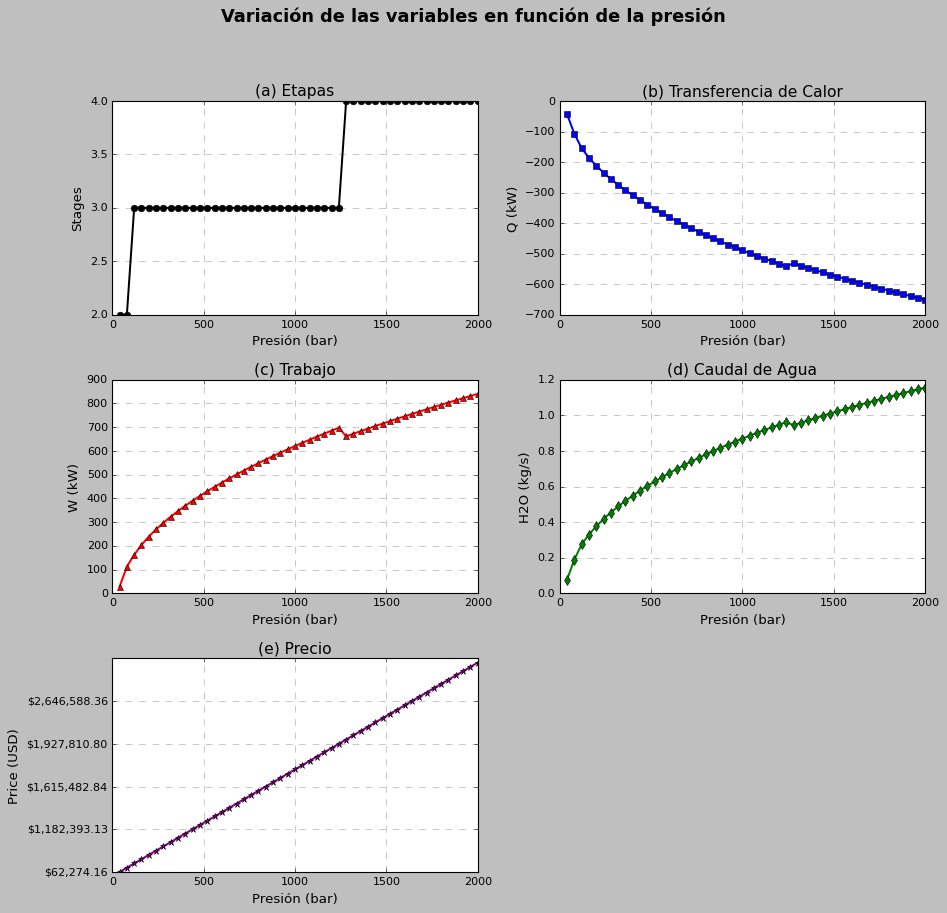

In [257]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker  # Para controlar la cantidad de ticks en el eje y

# Aplicamos el estilo clásico y actualizamos algunos parámetros estéticos
plt.style.use('classic')
plt.rcParams.update({
    'font.size': 12,             # Tamaño global de fuente
    'axes.labelsize': 12,        # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,        # Tamaño de los títulos de los ejes
    'xtick.labelsize': 10,       # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,       # Tamaño de las etiquetas del eje y
    'lines.linewidth': 1.8,      # Grosor de las líneas
    'lines.markersize': 6,       # Tamaño de los marcadores
    'grid.linestyle': '--',      # Estilo discontínuo para la rejilla
    'grid.linewidth': 0.75,      # Grosor de la rejilla
    'grid.color': '0.75',        # Color gris para la rejilla
})

# Se asume que las variables Pes, stages, Qk, Wk, waterr y price ya están definidas
resultados = pd.DataFrame({
    'P (bar)': Pes,
    'Stages': stages,
    'Q (kW)': Qk,
    'W (kW)': Wk,
    'H2O (kg/s)': waterr,
    'Price (USD)': price
})

# Configuración de la figura con 3 filas y 2 columnas (sin sharex para mostrar todos los valores en X)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Variación de las variables en función de la presión', fontsize=16, fontweight='bold')

# Panel (a): Stages vs. Presión
axs[0, 0].plot(resultados['P (bar)'], resultados['Stages'],
               marker='o', linestyle='-', color='black')
axs[0, 0].set_ylabel('Stages')
axs[0, 0].set_title('(a) Etapas')
axs[0, 0].grid(True)
axs[0, 0].set_axisbelow(True)
axs[0, 0].set_xlabel('Presión (bar)')  # Se muestran los valores del eje de la presión

# Panel (b): Q (kW) vs. Presión
axs[0, 1].plot(resultados['P (bar)'], resultados['Q (kW)'],
               marker='s', linestyle='-', color='blue')
axs[0, 1].set_ylabel('Q (kW)')
axs[0, 1].set_title('(b) Transferencia de Calor')
axs[0, 1].grid(True)
axs[0, 1].set_axisbelow(True)
axs[0, 1].set_xlabel('Presión (bar)')

# Panel (c): W (kW) vs. Presión
axs[1, 0].plot(resultados['P (bar)'], resultados['W (kW)'],
               marker='^', linestyle='-', color='red')
axs[1, 0].set_ylabel('W (kW)')
axs[1, 0].set_title('(c) Trabajo')
axs[1, 0].grid(True)
axs[1, 0].set_axisbelow(True)
axs[1, 0].set_xlabel('Presión (bar)')

# Panel (d): H2O (kg/s) vs. Presión
axs[1, 1].plot(resultados['P (bar)'], resultados['H2O (kg/s)'],
               marker='d', linestyle='-', color='green')
axs[1, 1].set_ylabel('H2O (kg/s)')
axs[1, 1].set_title('(d) Caudal de Agua')
axs[1, 1].grid(True)
axs[1, 1].set_axisbelow(True)
axs[1, 1].set_xlabel('Presión (bar)')

# Panel (e): Price (USD) vs. Presión
axs[2, 0].plot(resultados['P (bar)'], resultados['Price (USD)'],
               marker='*', linestyle='-', color='purple')
axs[2, 0].set_ylabel('Price (USD)')
axs[2, 0].set_title('(e) Precio')
axs[2, 0].grid(True)
axs[2, 0].set_axisbelow(True)
axs[2, 0].set_xlabel('Presión (bar)')
# Reducir el número de ticks en el eje y a un máximo de 5 para el gráfico de Price
axs[2, 0].yaxis.set_major_locator(ticker.MaxNLocator(5))

# Ocultamos el panel vacío (última celda de la cuadrícula)
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [258]:


P=172.4
Po=31
P_diff=P-Po
P1=Po
P2=P
N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
N_etapas
P_etapa=P_diff/N_etapas
Po=Po
Pf=P
P_acum=[Po]
Temps=[25+273.15]
Tref=Tref
m=m
eta=0.75
Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
for i in range(int(N_etapas)):
    P1=sum(P_acum)
    print(P1)
    P_acum.append(P_etapa)
    P2=sum(P_acum)
    #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
    #print('T',Ti)
    # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
    x0 = [1.0]
    sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta), method='hybr')
    if sol.success:
        print(sol.message)
    else:
        print(sol.message)

    resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15)
    print(f"W: {resultado:.20f} kW")
    # Se utiliza scipy.optimize.root con método 'hybr'
    solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

    if solucion.success:
        x_encontrado = solucion.x[0]
        print(f"Solución encontrada: x = {x_encontrado:.6f}")
        Temps.append(25+273.15)
        Qs.append(float(-e))
        Ts.append((25+273.15))
        m_H2O.append(float(x_encontrado))
        comp.append('No. '+str(i+1))
        CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
        CP=CP/2*1000
        power.append(resultado*1e3)
        Ps.append(P2)
    else:
        print("No se encontró solución:", solucion.message)
# Crear un DataFrame con los datos
data = {
	"Compressor": comp,
    "T (K)": Ts,
    "P (bar)": Ps,  # Convertir de Pa a bar
	"Cooling H2O (kg/s)": m_H2O,
	"Q (kW)": np.array(Qs),
    #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
    "W (kW)": np.array(power)
    #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
    
}

df_compresores = pd.DataFrame(data)

#df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]


31
kW 2103.5403006874303
kW 2103.5403006874303
kW 2103.5403006874303
kW 2103.5403174973912
kW 1947.3773942692658
kW 1946.11875899042
kW 1946.1085722418463
kW 1946.1085715650456
The solution converged.
W: 0.12013015873858305660 kW
Solución encontrada: x = 0.179396
78.13333333333333
kW 1091.5203751871707
kW 1091.5203751871707
kW 1091.5203751871707
kW 1091.5203838131429
kW 925.2316100034723
kW 923.2596209213932
kW 923.2337011454446
kW 923.2336962552089
kW 923.2336962551962
The solution converged.
W: 0.05698973433674051070 kW
Solución encontrada: x = 0.095388
125.26666666666665
kW 751.2935697169793
kW 751.2935697169793
kW 751.2935697169793
kW 751.2935755802413
kW 619.9227245577546
kW 618.3414872342253
kW 618.3192202840117
kW 618.3192153614324
kW 618.3192153614166
The solution converged.
W: 0.03816785280008743592 kW
Solución encontrada: x = 0.070319
